## GANサンプル

参照URL

[GANについて概念から実装まで　～DCGANによるキルミーベイベー生成～](https://qiita.com/taku-buntu/items/0093a68bfae0b0ff879d)

In [1]:
import warnings
warnings.filterwarnings('ignore')

# 必要ライブラリのロード

from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils import np_utils
import tensorflow as tf
from keras.backend import tensorflow_backend

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
import os
import numpy as np

In [3]:
#  作業用ディレクトリの準備
save_dir = 'images/gen_imgs'
os.makedirs(save_dir, exist_ok=True)
latent_dir = 'images/latent'
os.makedirs(latent_dir, exist_ok=True)
os.makedirs('ganmodels', exist_ok=True)

In [4]:
# 乱数初期化
np.random.seed(0)
np.random.RandomState(0)
tf.set_random_seed(0)

In [5]:
# イメージサイズ
shape = (128, 128, 3)

# 潜在変数次元数
z_dim = 100

In [6]:
# 生成器
def build_generator():
    noise_shape = (z_dim,)

    model = Sequential()

    model.add(Dense(128 * 32 * 32, activation="relu", input_shape=noise_shape))
    model.add(Reshape((32, 32, 128)))
    model.add(BatchNormalization(momentum=0.8))
    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size=3, padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(UpSampling2D())
    model.add(Conv2D(64, kernel_size=3, padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2D(3, kernel_size=3, padding="same"))
    model.add(Activation("tanh"))

    model.summary()

    noise = Input(shape=noise_shape)
    img = model(noise)

    return Model(noise, img)

In [7]:
# 判別器
def build_discriminator():
    img_shape = shape

    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0, 1), (0, 1))))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    model.summary()

    img = Input(shape=img_shape)
    validity = model(img)

    return Model(img, validity)

In [8]:
# GANモデル
def build_combined(generator, discriminator):
    discriminator.trainable = False
    model = Sequential([generator, discriminator])

    return model

In [9]:
optimizer = Adam(lr=0.0002, beta_1=0.5)
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 33, 33, 64)        0         
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 33, 33, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 33, 33, 64)        0         
__________

In [10]:
generator = build_generator()
# generator.compile(loss='binary_crossentropy', optimizer=optimizer)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 131072)            13238272  
_________________________________________________________________
reshape_1 (Reshape)          (None, 32, 32, 128)       0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 32, 32, 128)       512       
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 64, 128)       147584    
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 128)       0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 64, 64, 128)       512       
__________

In [11]:
z = Input(shape=(z_dim,))
img = generator(z)

discriminator.trainable = False

valid = discriminator(img)

combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

# 学習データの読み込み

In [12]:
from PIL import Image

In [13]:
!wget https://github.com/makaishi2/sample-data/raw/master/kill_me_baby.gz | tail -1

--2019-01-31 12:26:36--  https://github.com/makaishi2/sample-data/raw/master/kill_me_baby.gz
Resolving github.com (github.com)... 192.30.253.112, 192.30.253.113
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/makaishi2/sample-data/master/kill_me_baby.gz [following]
--2019-01-31 12:26:36--  https://raw.githubusercontent.com/makaishi2/sample-data/master/kill_me_baby.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.48.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.48.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20670367 (20M) [application/octet-stream]
Saving to: ‘kill_me_baby.gz.1’

kill_me_baby.gz.1   100%[===================>]  19.71M  --.-KB/s    in 0.1s    

2019-01-31 12:26:37 (167 MB/s) - ‘kill_me_baby.gz.1’ saved [20670367/20670367]



In [14]:
!tar xzvf kill_me_baby.gz

kill_me_baby_datasets/
kill_me_baby_datasets/botsu/
kill_me_baby_datasets/yasuna&sonya&agiri/
kill_me_baby_datasets/others/
kill_me_baby_datasets/yasuna&sonya/
kill_me_baby_datasets/yasuna&agiri/
kill_me_baby_datasets/yasuna/
kill_me_baby_datasets/sonya/
kill_me_baby_datasets/agiri/
kill_me_baby_datasets/agiri/09_071.png
kill_me_baby_datasets/agiri/01_088.png
kill_me_baby_datasets/agiri/01_077.png
kill_me_baby_datasets/agiri/09_064.png
kill_me_baby_datasets/agiri/05_042.png
kill_me_baby_datasets/agiri/09_072.png
kill_me_baby_datasets/agiri/01_075.png
kill_me_baby_datasets/agiri/09_073.png
kill_me_baby_datasets/agiri/05_051.png
kill_me_baby_datasets/agiri/02_039.png
kill_me_baby_datasets/agiri/01_071.png
kill_me_baby_datasets/agiri/06_030.png
kill_me_baby_datasets/agiri/02_038.png
kill_me_baby_datasets/agiri/01_073.png
kill_me_baby_datasets/agiri/04_056.png
kill_me_baby_datasets/agiri/02_048.png
kill_me_baby_datasets/agiri/12_063.png
kill_me_baby_datasets/agiri/11_017.png
kill_me_baby_d

In [15]:
root_dir = './kill_me_baby_datasets'
class_names = os.listdir(root_dir)

In [16]:
print(class_names)

['yasuna&sonya&agiri', 'botsu', 'yasuna', 'others', 'sonya', 'yasuna&agiri', 'yasuna&sonya', 'agiri']


In [17]:
# ラベルのone hot化
def get_class_one_hot(class_str):
    label_encoded = class_names.index(class_str)
    label_hot = np_utils.to_categorical(label_encoded, len(class_names))
    return label_hot

In [18]:
# イメージ読み込み
def load_imgs():

    img_paths = []
    labels = []
    images = np.empty((0,128,128,3))

    for cl_name in class_names:
        img_names = os.listdir(os.path.join(root_dir, cl_name))
        for img_name in img_names:
            img_path = os.path.abspath(os.path.join(root_dir, cl_name, img_name))
            img = Image.open(img_path)
            img_array = np.array(img)
            img_shape = img_array.shape
            if (img_shape == (128,128,3)):
                img_array2 = np.expand_dims(img_array, axis=0)
                images = np.concatenate((images, img_array2), axis=0)
                hot_cl_name = get_class_one_hot(cl_name)
                labels.append(hot_cl_name)

    return (images, np.array(labels))

In [19]:
images, labels = load_imgs()

In [20]:
print(images.shape)

(684, 128, 128, 3)


In [21]:
print(labels.shape)

(684, 8)


In [22]:
# イメージ書き出し
def save_imgs(iteration, check_noise, r, c):
    noise = check_noise
    gen_imgs = generator.predict(noise)

    # 0-1 rescale
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, :])
            axs[i, j].axis('off')
            cnt += 1
    fig.savefig('%s/kill_me_%d.png' % (save_dir,iteration))
    plt.close()

In [23]:
def visualizeInterpolation(start, end, save=True, nbSteps=10):
    print("Generating interpolations...")

    steps = nbSteps
    latentStart = start
    latentEnd = end

    startImg = generator.predict(latentStart)
    endImg = generator.predict(latentEnd)

    vectors = []

    alphaValues = np.linspace(0, 1, steps)
    for alpha in alphaValues:
        vector = latentStart * (1 - alpha) + latentEnd * alpha
        vectors.append(vector)

    vectors = np.array(vectors)

    resultLatent = None
    resultImage = None

    for i, vec in enumerate(vectors):
        gen_img = np.squeeze(generator.predict(vec), axis=0)
        gen_img = (0.5 * gen_img + 0.5) * 255
        gen_img2 = np.expand_dims(gen_img, axis=0)
        # interpolatedImage = cv2.cvtColor(gen_img, cv2.COLOR_RGB2BGR)
        # interpolatedImage = interpolatedImage.astype(np.uint8)
        resultImage = gen_img2 if resultImage is None else np.concatenate((resultImage, gen_img2), axis=0)
    return resultImage

In [24]:
# 学習用変数設定
batch_size = 32
#iterations = 200000
#save_interval = 1000
#model_interval = 5000

#iterations = 1000
#disp_interval = 100
#save_interval = 100
#model_interval = 100

iterations = 100000
disp_interval = 1000
save_interval = 5000
model_interval = 5000

r = 5
c = 5
check_noise = np.random.uniform(-1, 1, (r * c, 100))

In [25]:
# 入力データ準備
X_train, labels = load_imgs()

half_batch = int(batch_size / 2)

X_train = (X_train.astype(np.float32) - 127.5) / 127.5

In [26]:
# main loop

for iteration in range(iterations):

    # ------------------
    # Training Discriminator
    # -----------------
    idx = np.random.randint(0, X_train.shape[0], half_batch)

    imgs = X_train[idx]

    noise = np.random.uniform(-1, 1, (half_batch, z_dim))

    gen_imgs = generator.predict(noise)

    d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
    d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))

    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # -----------------
    # Training Generator
    # -----------------

    noise = np.random.uniform(-1, 1, (batch_size, z_dim))

    g_loss = combined.train_on_batch(noise, np.ones((batch_size, 1)))
    
    if iteration % disp_interval == 0:
        print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (iteration, d_loss[0], 100 * d_loss[1], g_loss))

    if iteration % save_interval == 0:
        save_imgs(iteration, check_noise, r, c)
        start = np.expand_dims(check_noise[0], axis=0)
        end = np.expand_dims(check_noise[1], axis=0)
        resultImage = visualizeInterpolation(start=start, end=end)
        pil_img = Image.fromarray(np.uint8(resultImage[0]))
        resultFn = latent_dir + "/latent_{}.png".format(iteration)
        pil_img.save(resultFn)

    if iteration % model_interval == 0:
        generator.save("ganmodels/dcgan-{}-iter.h5".format(iteration))

 

0 [D loss: 1.810685, acc.: 15.62%] [G loss: 0.247997]
Generating interpolations...
1000 [D loss: 0.426913, acc.: 71.88%] [G loss: 4.018016]
2000 [D loss: 0.264904, acc.: 84.38%] [G loss: 5.212813]
3000 [D loss: 0.275198, acc.: 81.25%] [G loss: 6.226729]
4000 [D loss: 0.299165, acc.: 93.75%] [G loss: 5.837486]
5000 [D loss: 0.209168, acc.: 90.62%] [G loss: 3.783403]
Generating interpolations...
6000 [D loss: 0.149680, acc.: 93.75%] [G loss: 8.972551]
7000 [D loss: 0.082623, acc.: 93.75%] [G loss: 6.413553]
8000 [D loss: 0.033280, acc.: 100.00%] [G loss: 8.673372]
9000 [D loss: 3.822504, acc.: 56.25%] [G loss: 13.956351]
10000 [D loss: 0.070728, acc.: 93.75%] [G loss: 8.627046]
Generating interpolations...
11000 [D loss: 0.335063, acc.: 90.62%] [G loss: 11.123259]
12000 [D loss: 0.008012, acc.: 100.00%] [G loss: 12.498615]
13000 [D loss: 0.739312, acc.: 84.38%] [G loss: 14.198737]
14000 [D loss: 0.037914, acc.: 96.88%] [G loss: 14.090603]
15000 [D loss: 0.008862, acc.: 100.00%] [G loss: 

In [27]:
!ls -l images/gen_imgs

total 3136
-rw-r----- 1 gpuuser gpuuser 122449 Jan 31 12:33 kill_me_0.png
-rw-r----- 1 gpuuser gpuuser 105556 Jan 31 13:26 kill_me_10000.png
-rw-r----- 1 gpuuser gpuuser 108755 Jan 31 12:17 kill_me_100.png
-rw-r----- 1 gpuuser gpuuser 107008 Jan 31 13:52 kill_me_15000.png
-rw-r----- 1 gpuuser gpuuser 107781 Jan 31 14:18 kill_me_20000.png
-rw-r----- 1 gpuuser gpuuser 108331 Jan 31 12:17 kill_me_200.png
-rw-r----- 1 gpuuser gpuuser 107881 Jan 31 14:45 kill_me_25000.png
-rw-r----- 1 gpuuser gpuuser 108357 Jan 31 15:11 kill_me_30000.png
-rw-r----- 1 gpuuser gpuuser 109636 Jan 31 12:18 kill_me_300.png
-rw-r----- 1 gpuuser gpuuser 106855 Jan 31 15:37 kill_me_35000.png
-rw-r----- 1 gpuuser gpuuser 106766 Jan 31 16:04 kill_me_40000.png
-rw-r----- 1 gpuuser gpuuser 108649 Jan 31 12:18 kill_me_400.png
-rw-r----- 1 gpuuser gpuuser 107642 Jan 31 16:30 kill_me_45000.png
-rw-r----- 1 gpuuser gpuuser 106190 Jan 31 16:56 kill_me_50000.png
-rw-r----- 1 gpuuser gpuuser 107144 Jan 31 12:59 kill_me_5000.p

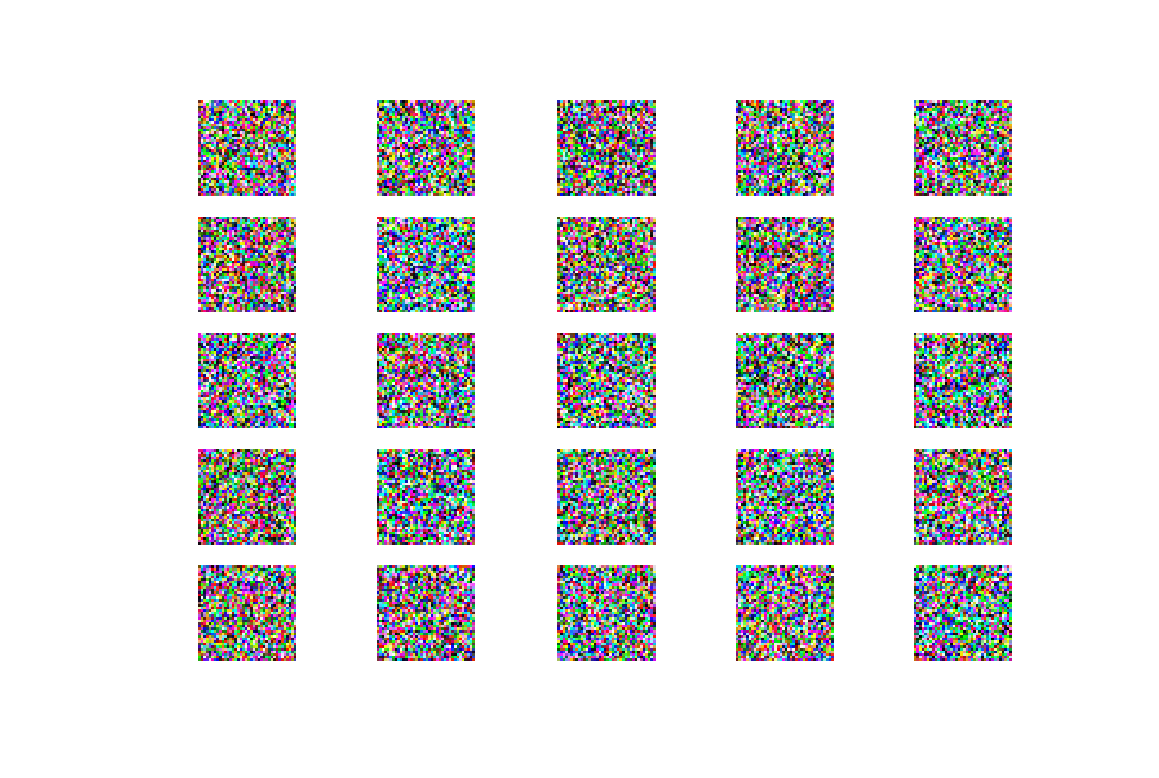

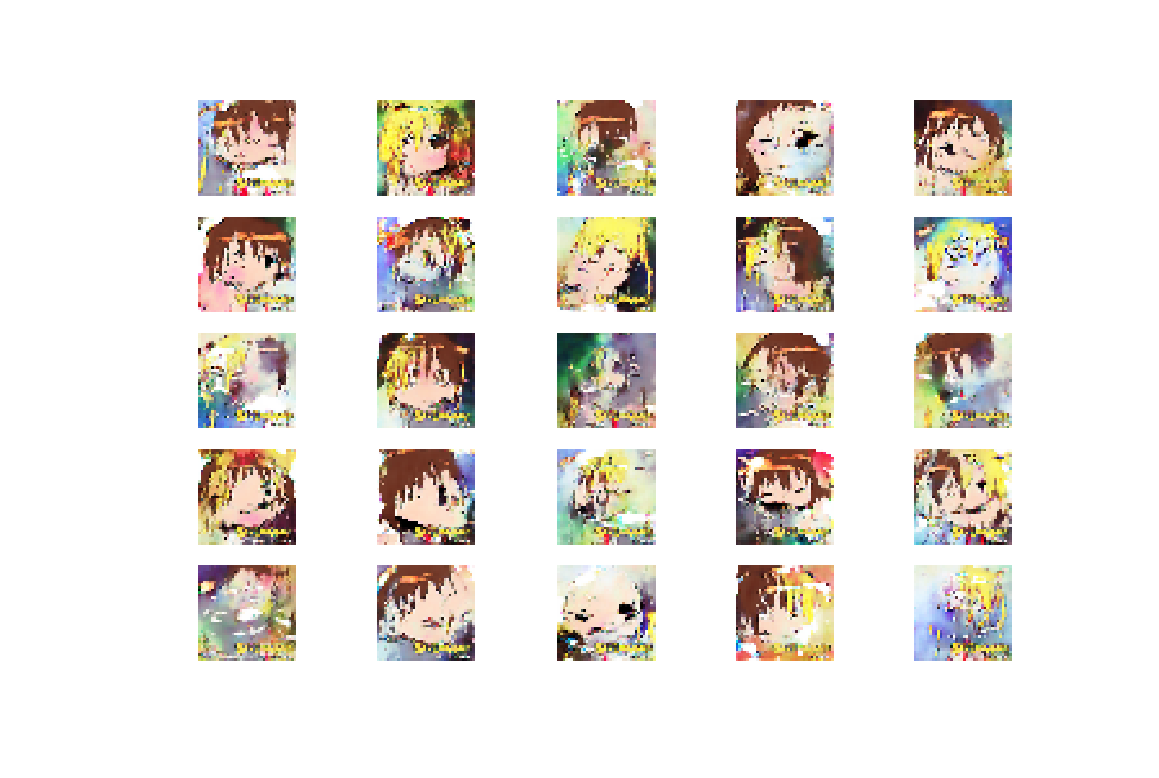

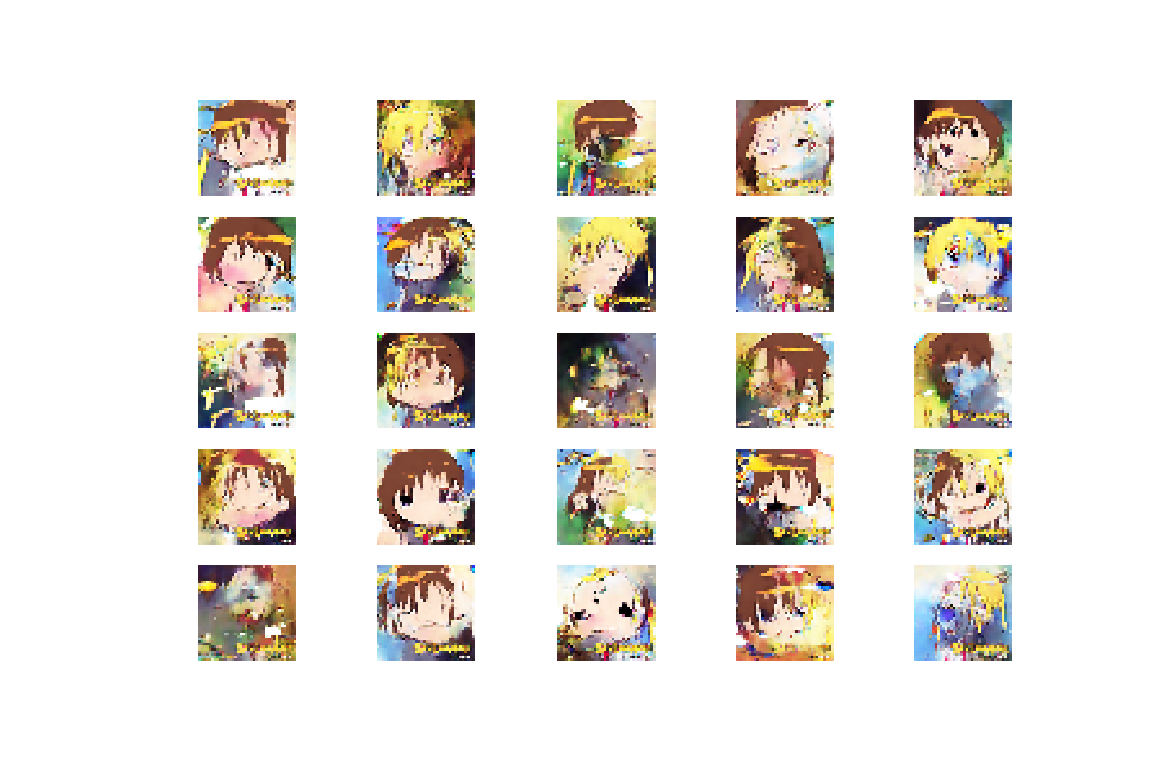

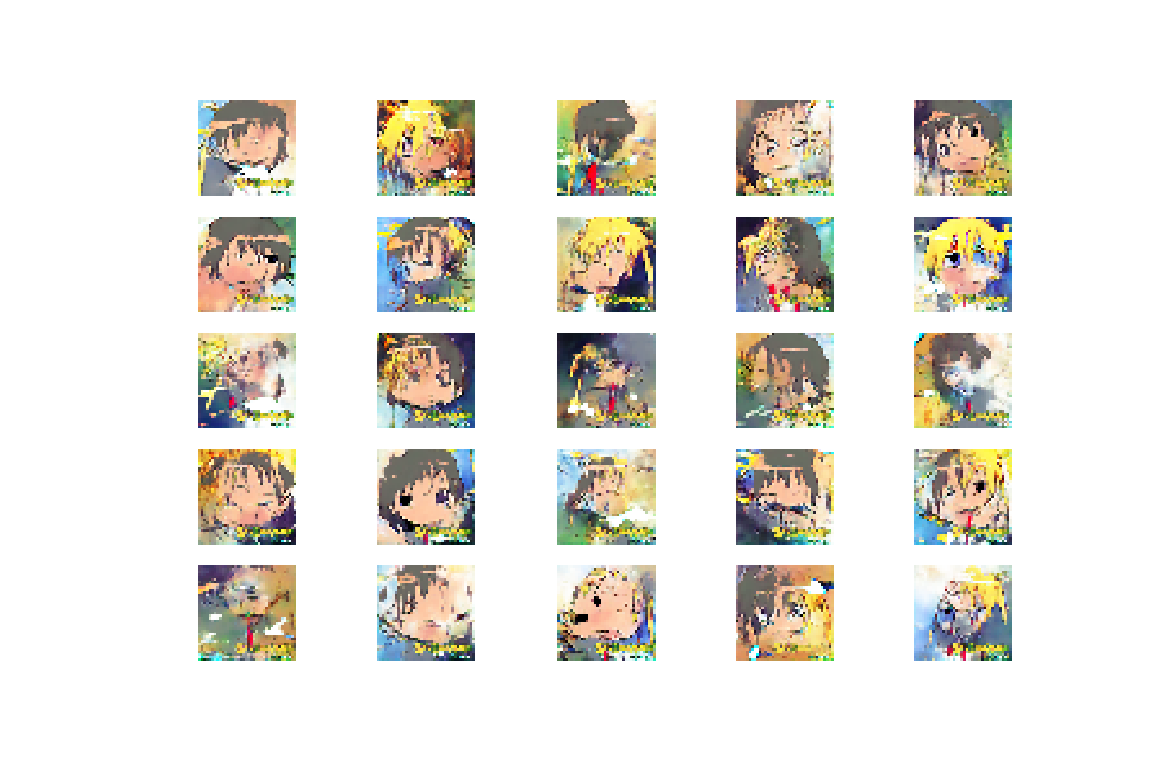

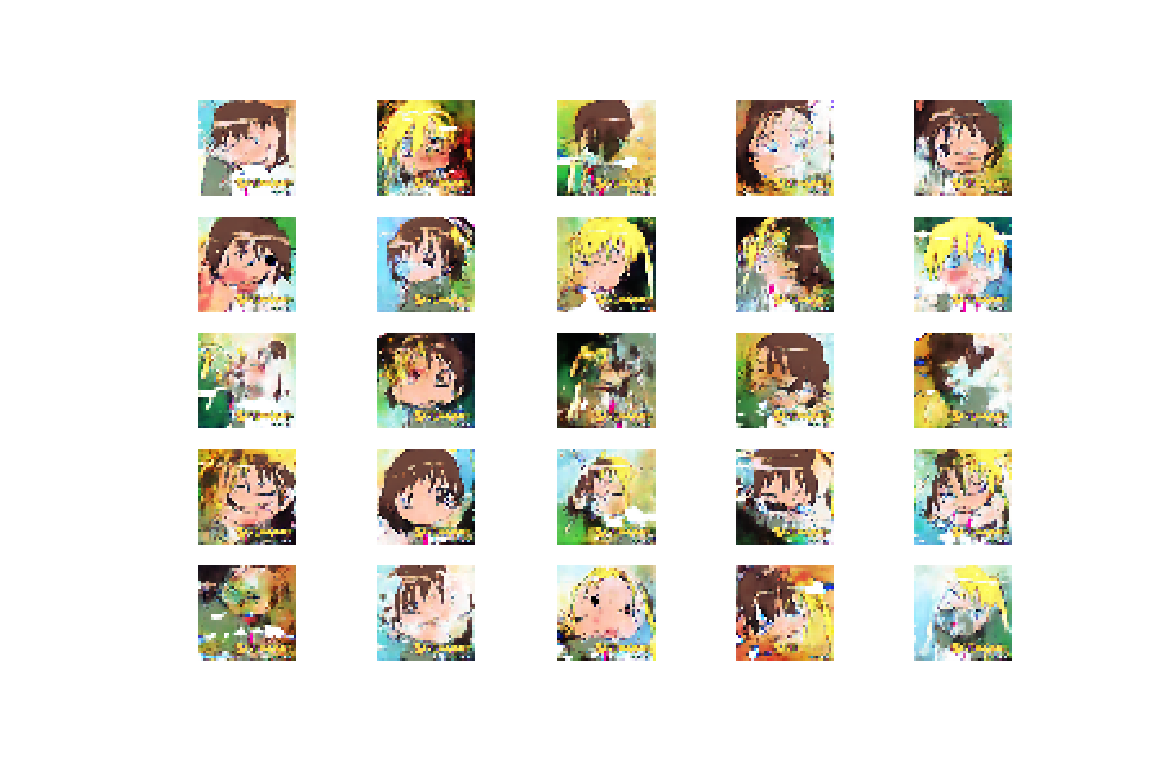

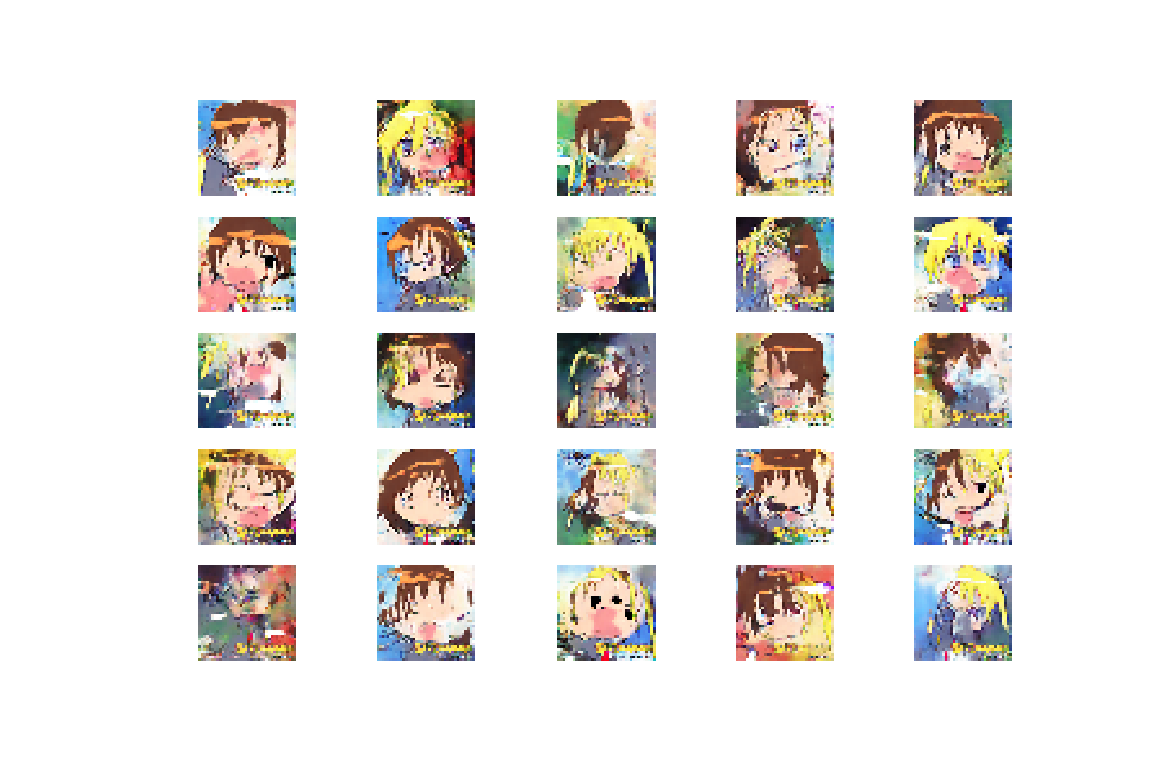

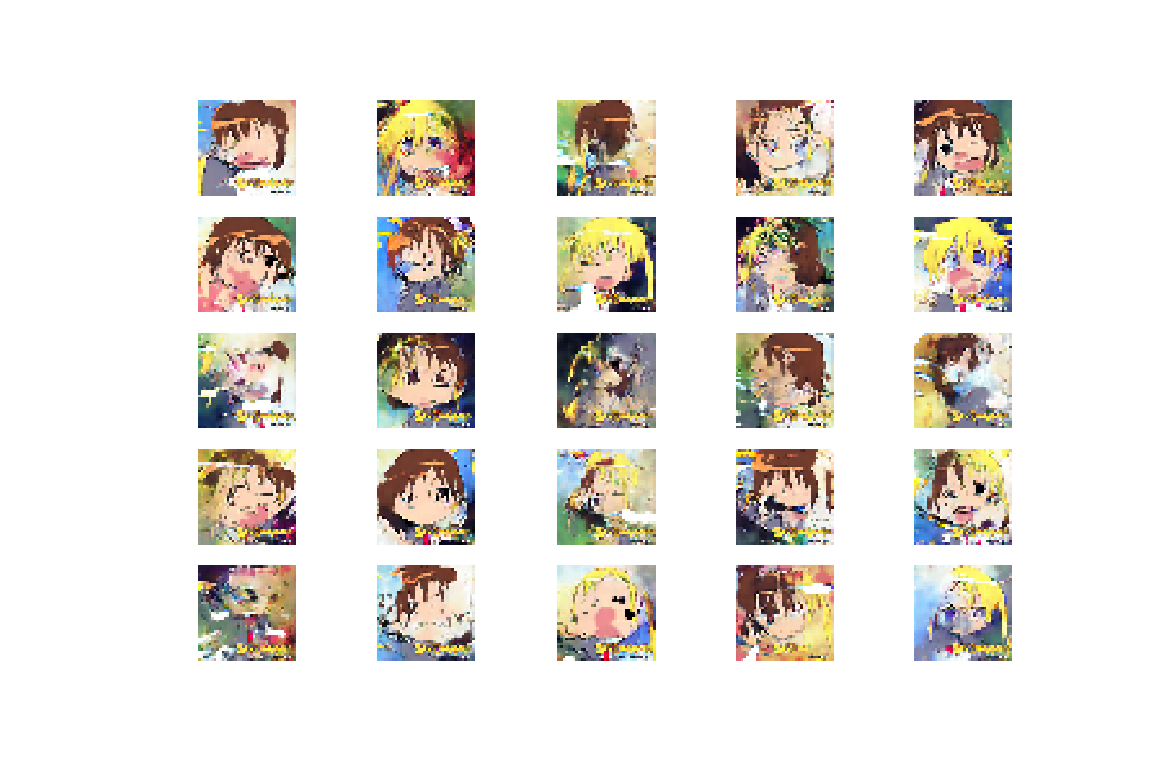

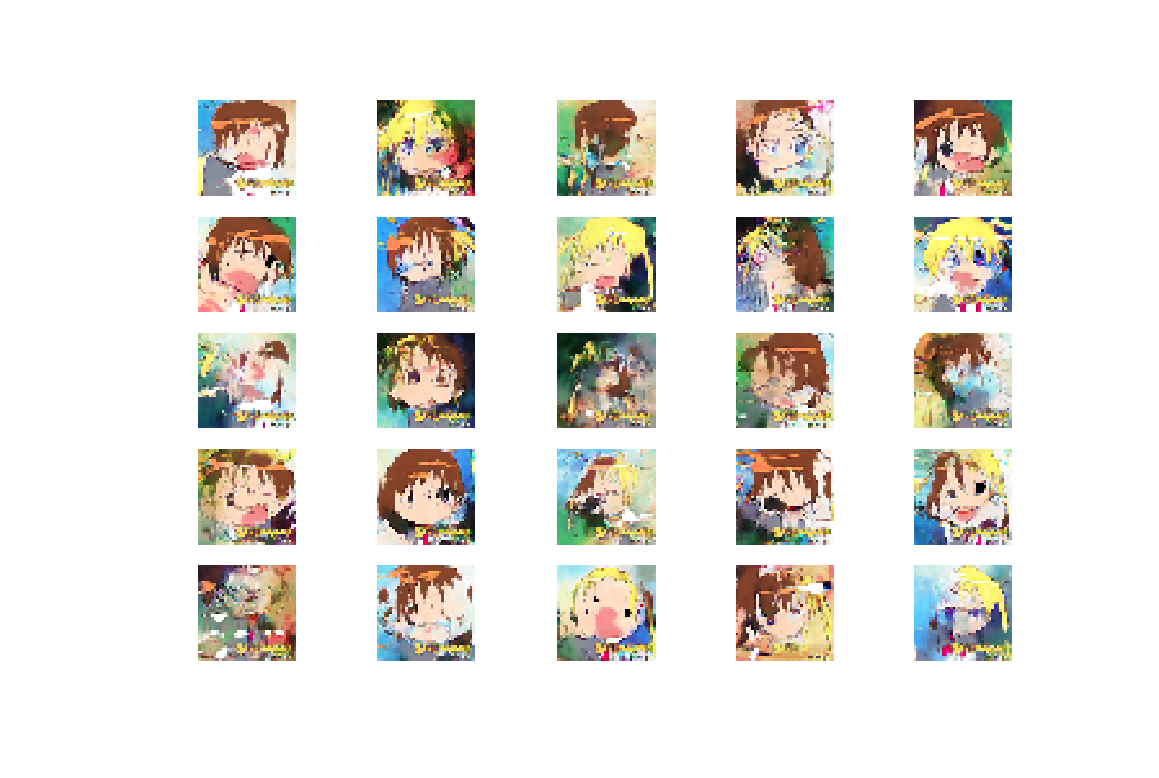

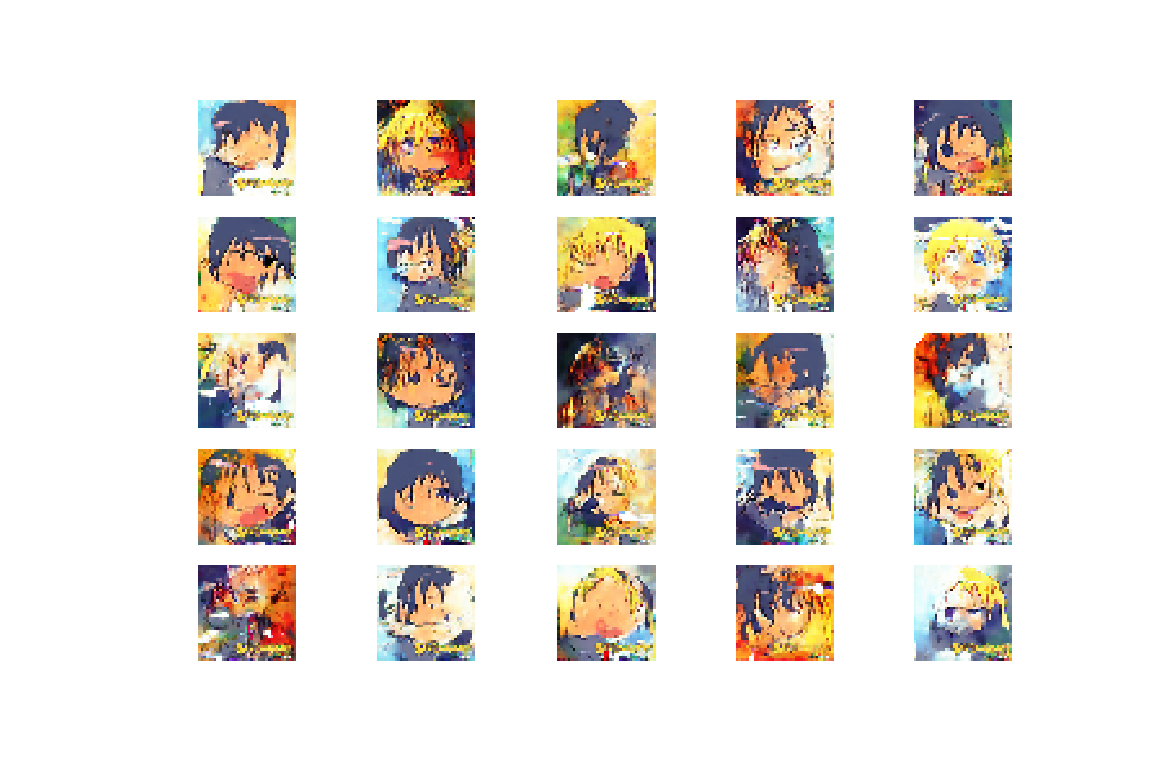

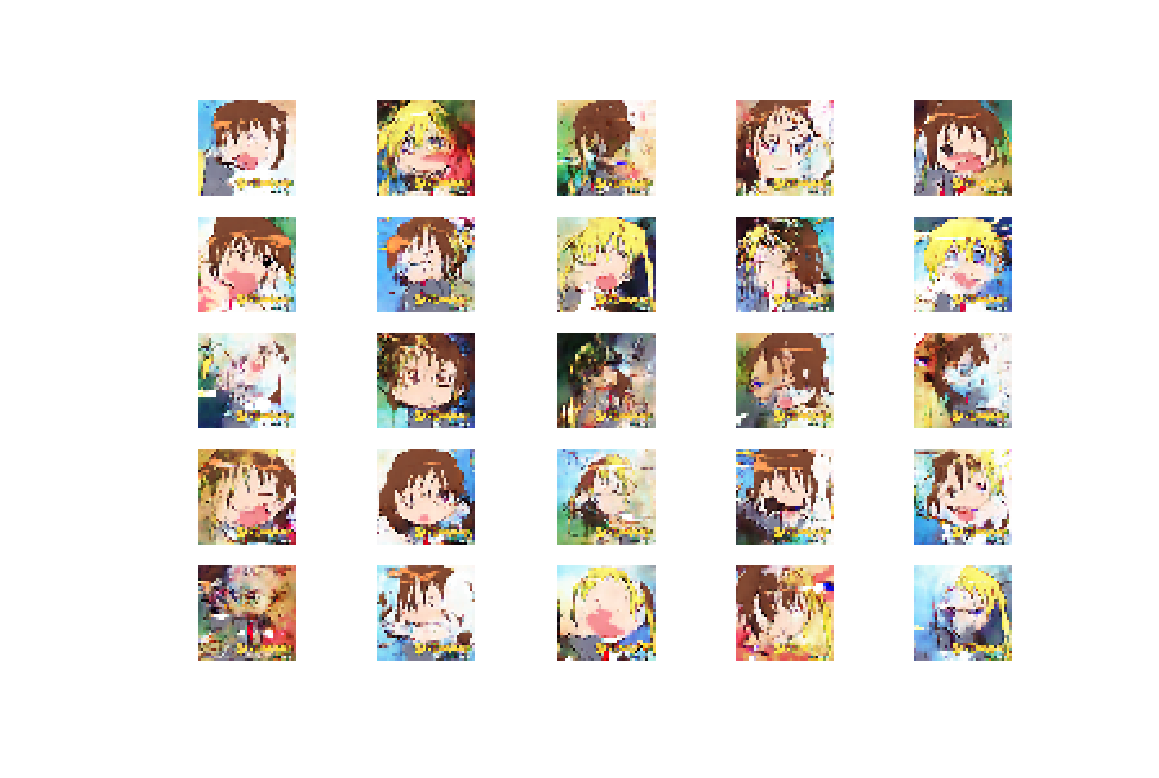

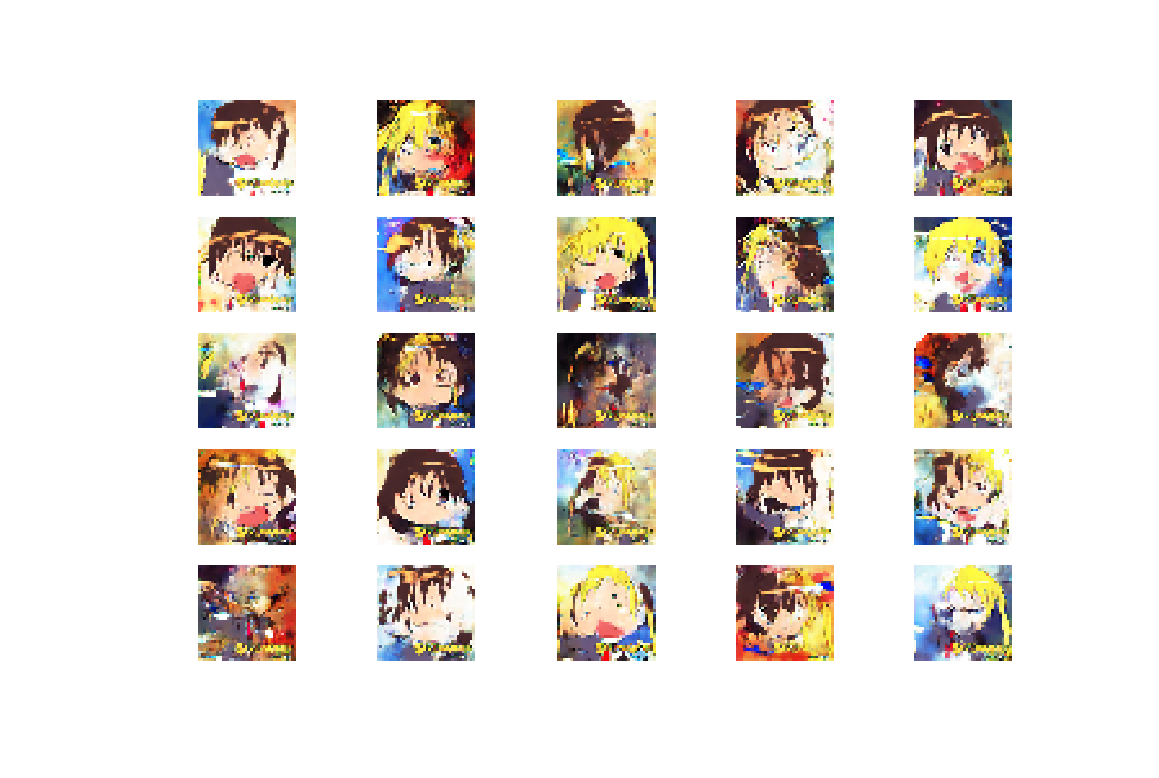

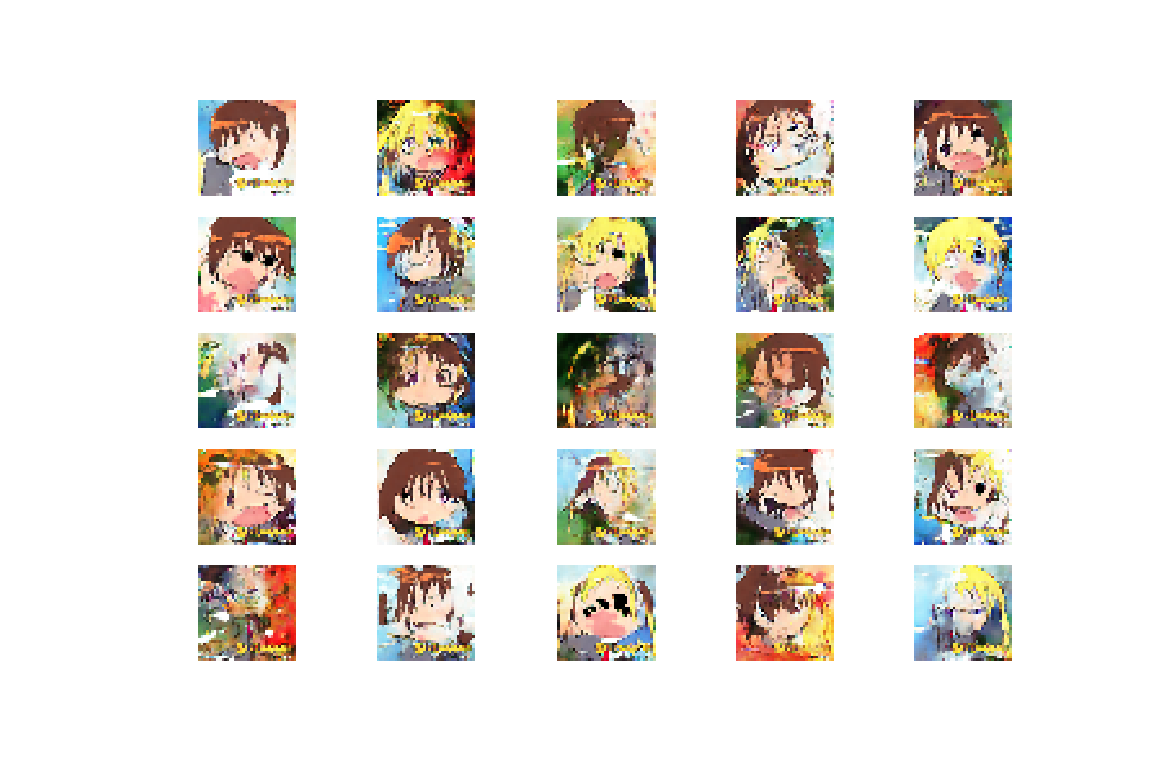

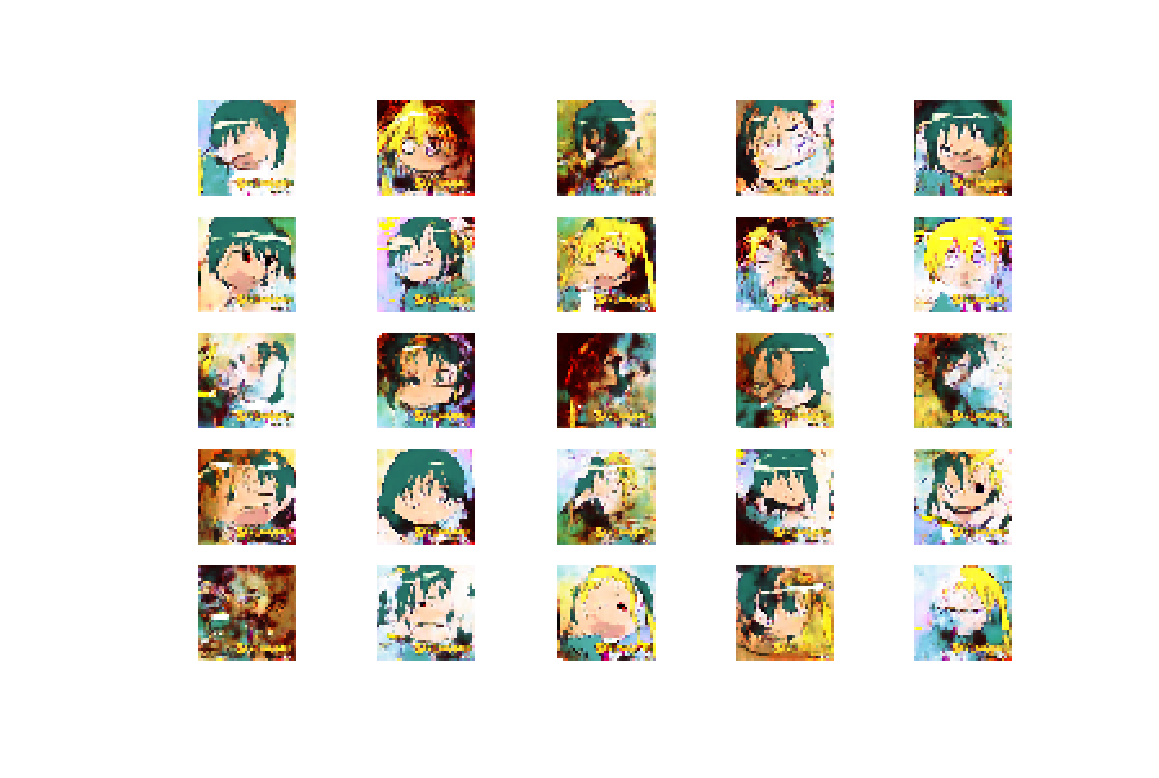

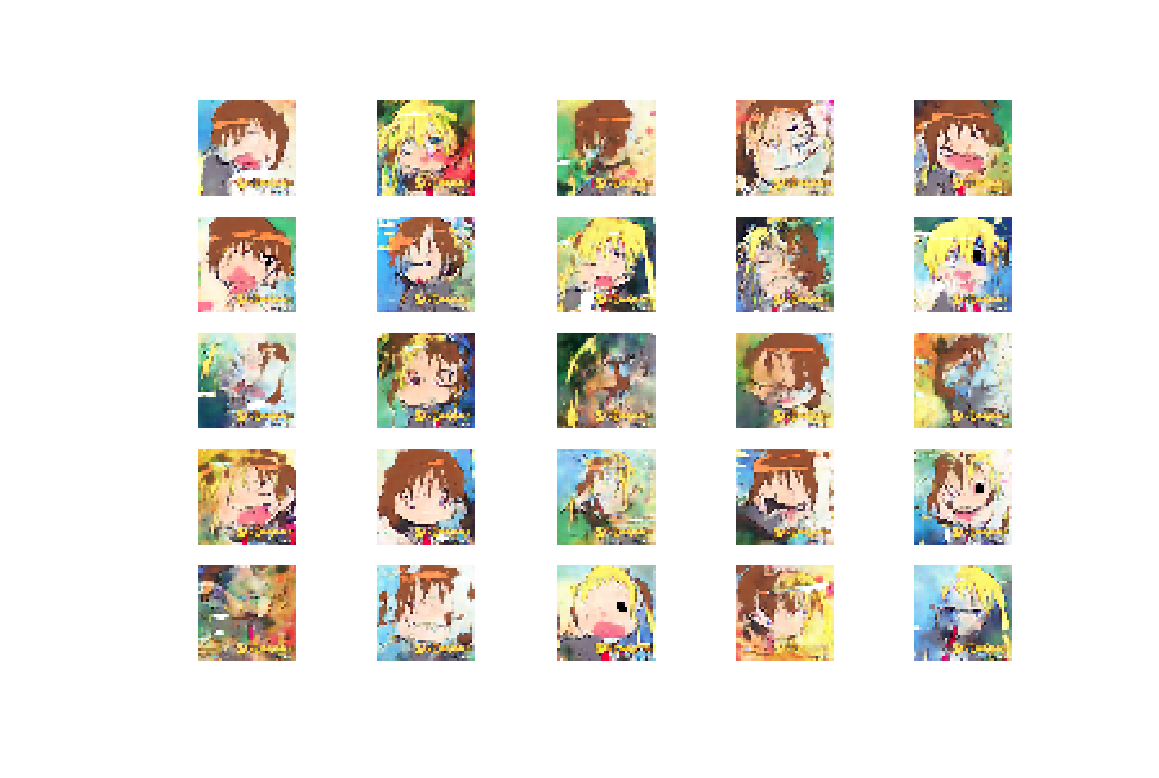

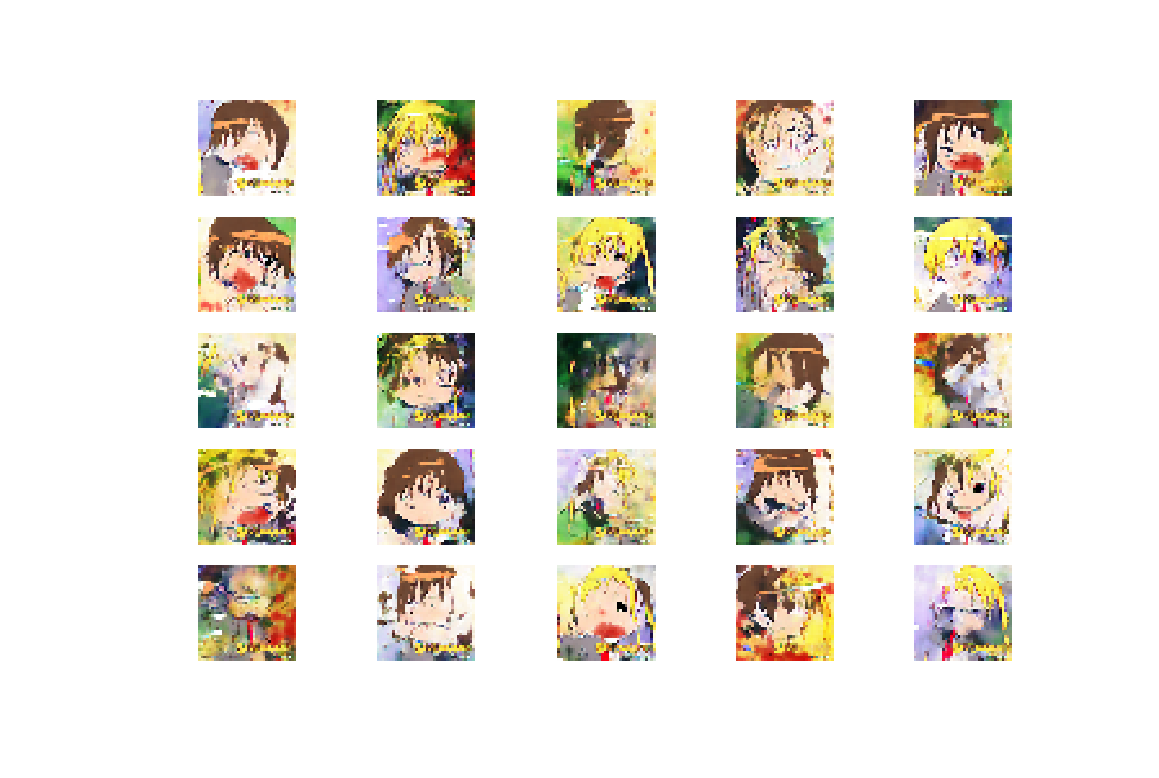

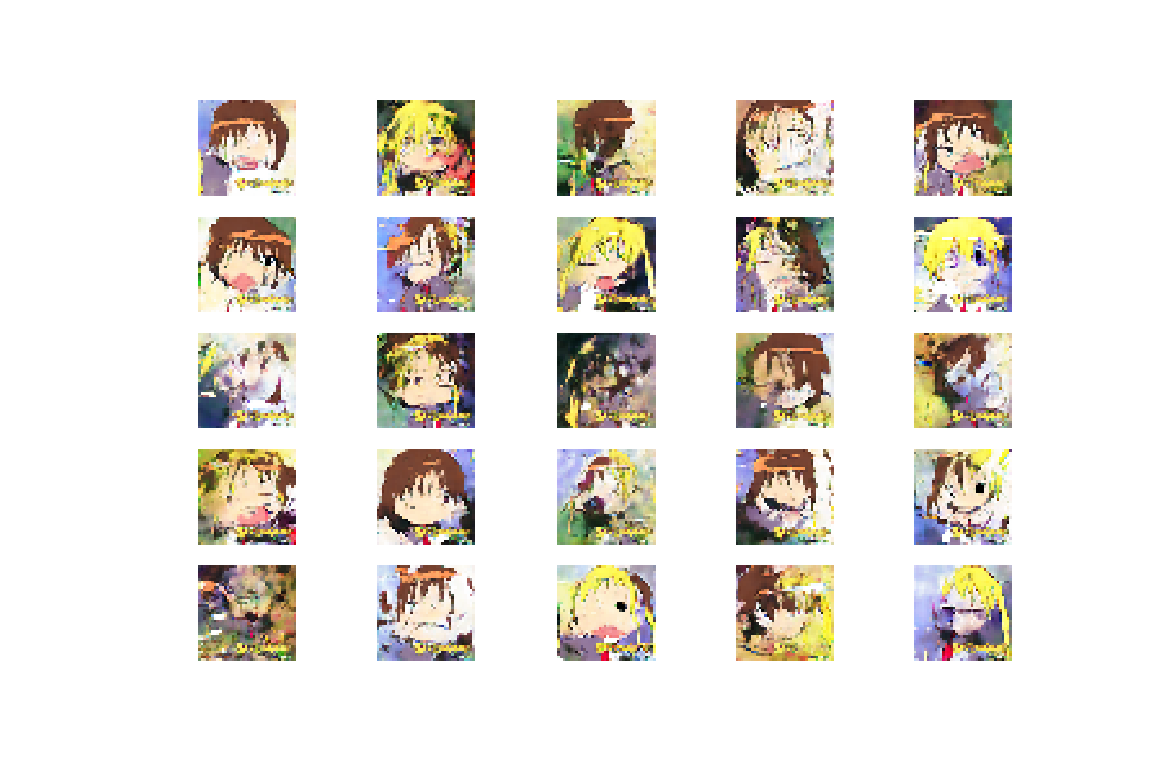

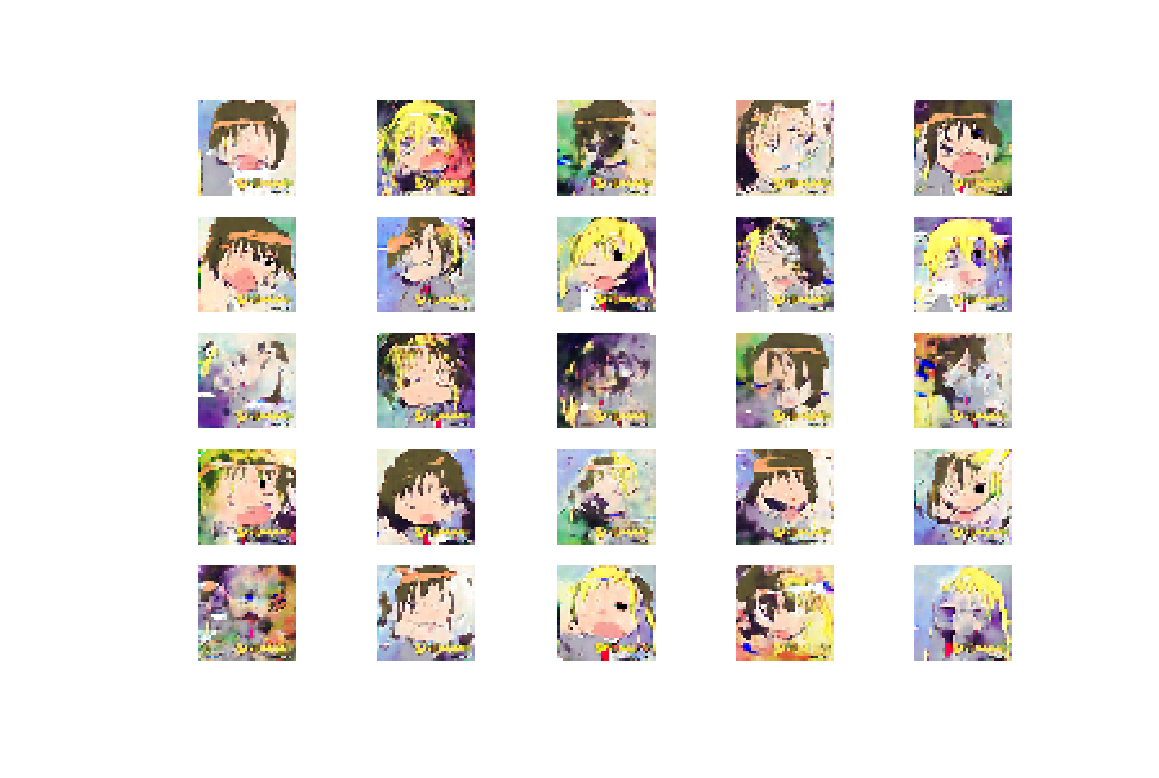

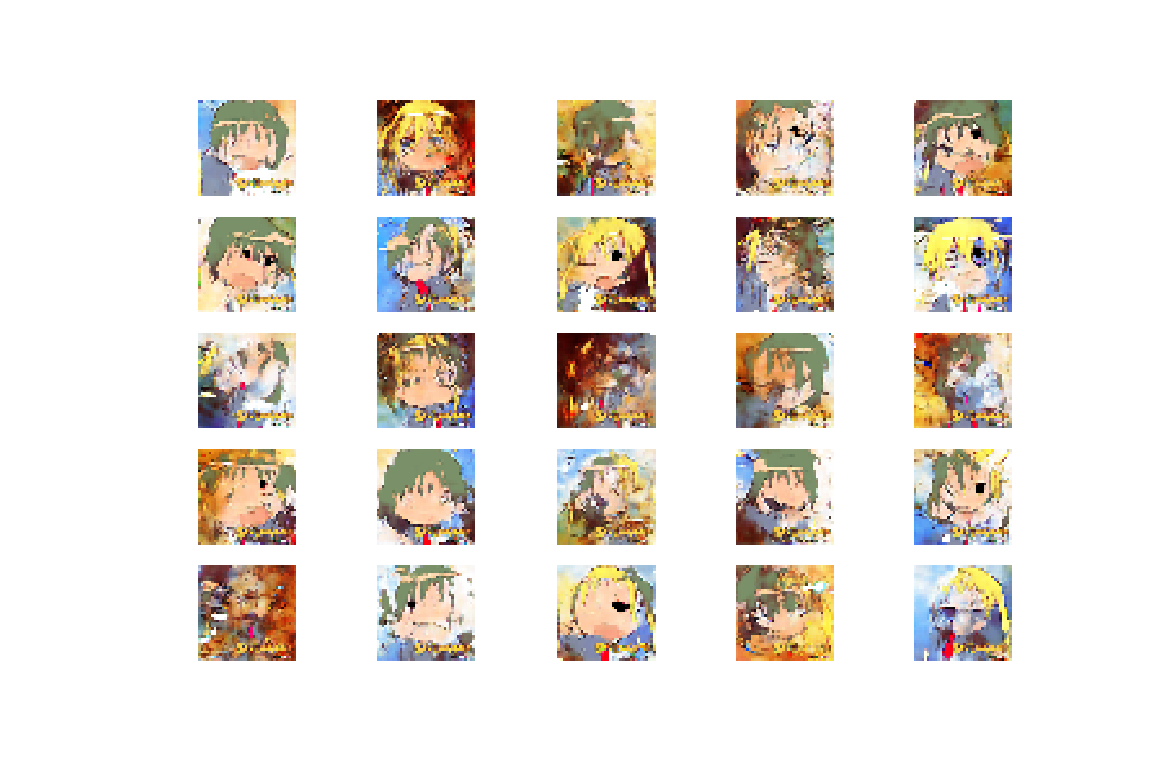

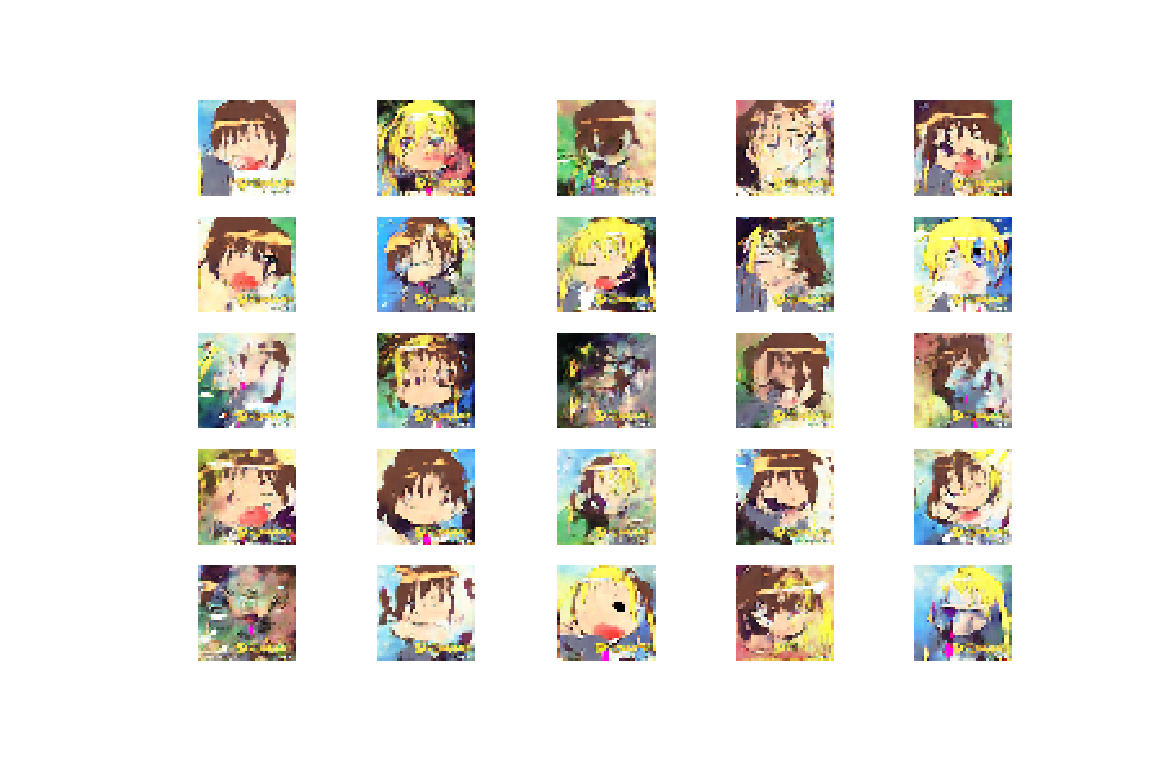

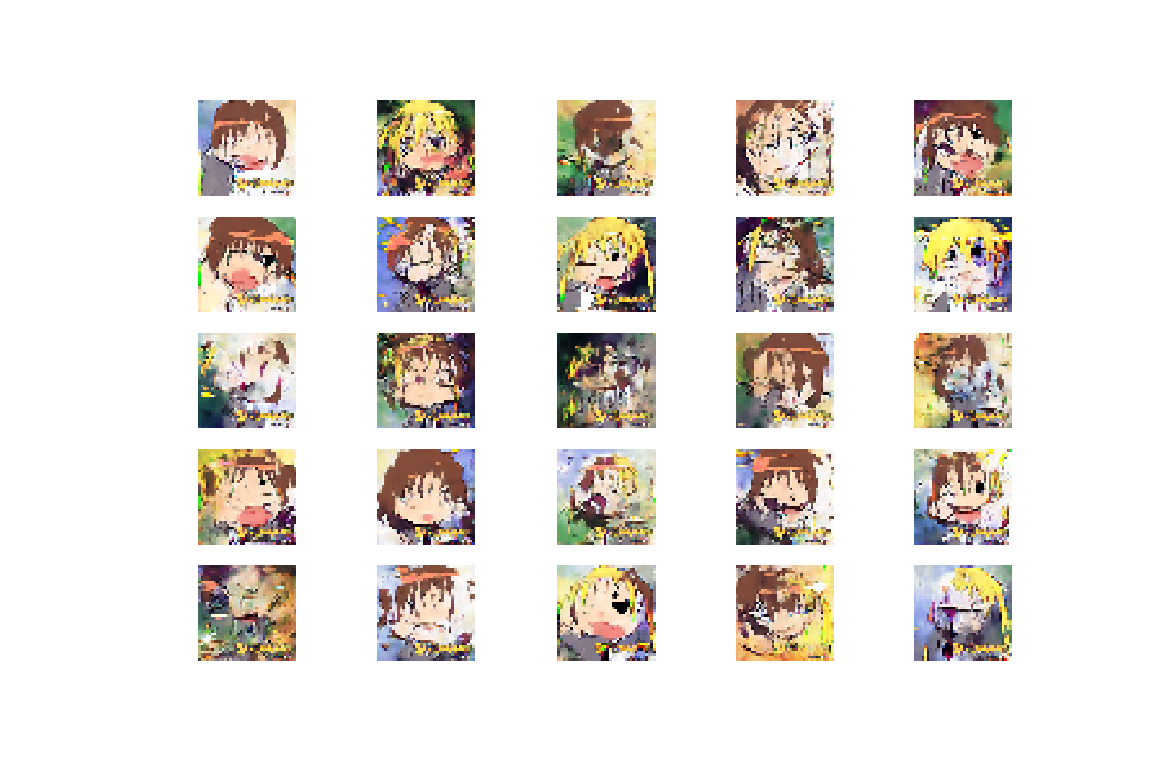

In [28]:
for i in range(0,100000,5000):
    fn = 'images/gen_imgs/kill_me_%d.png' % i
    im = Image.open(fn)
    plt.figure(figsize=(20,20))
    plt.axis('off')
    plt.imshow(np.array(im))
    plt.show()

In [29]:
!ls -l images/latent

total 1020
-rw-r----- 1 gpuuser gpuuser 47997 Jan 31 12:33 latent_0.png
-rw-r----- 1 gpuuser gpuuser 32062 Jan 31 13:26 latent_10000.png
-rw-r----- 1 gpuuser gpuuser 37017 Jan 31 12:17 latent_100.png
-rw-r----- 1 gpuuser gpuuser 31564 Jan 31 13:52 latent_15000.png
-rw-r----- 1 gpuuser gpuuser 31005 Jan 31 14:18 latent_20000.png
-rw-r----- 1 gpuuser gpuuser 37223 Jan 31 12:17 latent_200.png
-rw-r----- 1 gpuuser gpuuser 32013 Jan 31 14:45 latent_25000.png
-rw-r----- 1 gpuuser gpuuser 31670 Jan 31 15:11 latent_30000.png
-rw-r----- 1 gpuuser gpuuser 37502 Jan 31 12:18 latent_300.png
-rw-r----- 1 gpuuser gpuuser 30873 Jan 31 15:37 latent_35000.png
-rw-r----- 1 gpuuser gpuuser 30192 Jan 31 16:04 latent_40000.png
-rw-r----- 1 gpuuser gpuuser 37139 Jan 31 12:18 latent_400.png
-rw-r----- 1 gpuuser gpuuser 30455 Jan 31 16:30 latent_45000.png
-rw-r----- 1 gpuuser gpuuser 29705 Jan 31 16:56 latent_50000.png
-rw-r----- 1 gpuuser gpuuser 34073 Jan 31 12:59 latent_5000.png
-rw-r----- 1 gpuuser gpuuse

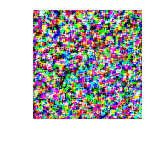

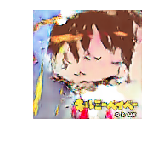

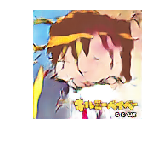

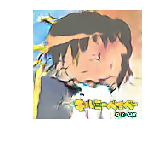

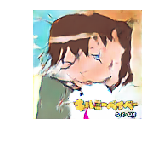

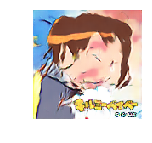

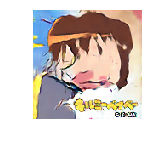

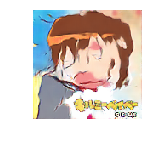

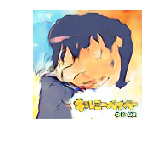

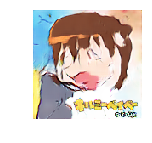

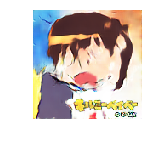

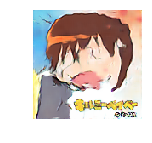

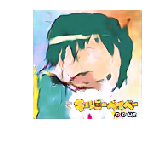

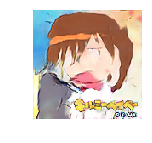

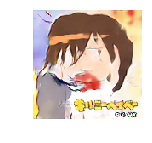

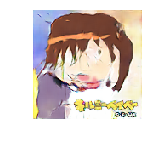

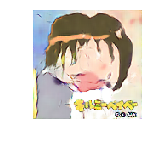

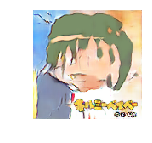

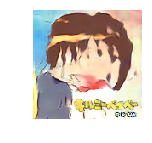

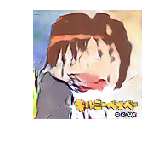

In [30]:
for i in range(0,100000,5000):
    fn = 'images/latent/latent_%d.png' % i
    im = Image.open(fn)
    plt.figure(figsize=(2,2))
    plt.axis('off')
    plt.imshow(np.array(im))
    plt.show()

In [31]:
!ls -l ganmodels

total 1525864
-rw-r----- 1 gpuuser gpuuser 53878192 Jan 31 12:33 dcgan-0-iter.h5
-rw-r----- 1 gpuuser gpuuser 53878192 Jan 31 13:26 dcgan-10000-iter.h5
-rw-r----- 1 gpuuser gpuuser 53878208 Jan 31 12:17 dcgan-100-iter.h5
-rw-r----- 1 gpuuser gpuuser 53878192 Jan 31 13:52 dcgan-15000-iter.h5
-rw-r----- 1 gpuuser gpuuser 53878192 Jan 31 14:18 dcgan-20000-iter.h5
-rw-r----- 1 gpuuser gpuuser 53878208 Jan 31 12:17 dcgan-200-iter.h5
-rw-r----- 1 gpuuser gpuuser 53878192 Jan 31 14:45 dcgan-25000-iter.h5
-rw-r----- 1 gpuuser gpuuser 53878192 Jan 31 15:11 dcgan-30000-iter.h5
-rw-r----- 1 gpuuser gpuuser 53878208 Jan 31 12:18 dcgan-300-iter.h5
-rw-r----- 1 gpuuser gpuuser 53878192 Jan 31 15:37 dcgan-35000-iter.h5
-rw-r----- 1 gpuuser gpuuser 53878192 Jan 31 16:04 dcgan-40000-iter.h5
-rw-r----- 1 gpuuser gpuuser 53878208 Jan 31 12:18 dcgan-400-iter.h5
-rw-r----- 1 gpuuser gpuuser 53878192 Jan 31 16:30 dcgan-45000-iter.h5
-rw-r----- 1 gpuuser gpuuser 53878192 Jan 31 16:56 dcgan-50000-iter.h5
-rw-

In [32]:
! tar czvf gan-result.gz ganmodels images/latent images/gen_imgs

ganmodels/
ganmodels/dcgan-90000-iter.h5
ganmodels/dcgan-75000-iter.h5
ganmodels/dcgan-20000-iter.h5
ganmodels/dcgan-600-iter.h5
ganmodels/dcgan-100-iter.h5
ganmodels/dcgan-60000-iter.h5
ganmodels/dcgan-25000-iter.h5
ganmodels/dcgan-30000-iter.h5
ganmodels/dcgan-45000-iter.h5
ganmodels/dcgan-15000-iter.h5
ganmodels/dcgan-95000-iter.h5
ganmodels/dcgan-35000-iter.h5
ganmodels/dcgan-70000-iter.h5
ganmodels/dcgan-900-iter.h5
ganmodels/dcgan-0-iter.h5
ganmodels/dcgan-65000-iter.h5
ganmodels/dcgan-200-iter.h5
ganmodels/dcgan-40000-iter.h5
ganmodels/dcgan-10000-iter.h5
ganmodels/dcgan-50000-iter.h5
ganmodels/dcgan-80000-iter.h5
ganmodels/dcgan-800-iter.h5
ganmodels/dcgan-300-iter.h5
ganmodels/dcgan-500-iter.h5
ganmodels/dcgan-85000-iter.h5
ganmodels/dcgan-700-iter.h5
ganmodels/dcgan-55000-iter.h5
ganmodels/dcgan-5000-iter.h5
ganmodels/dcgan-400-iter.h5
images/latent/
images/latent/latent_55000.png
images/latent/latent_20000.png
images/latent/latent_60000.png
images/latent/latent_100.png
image

In [33]:

# @hidden_cell
# The following code contains the credentials for a file in your IBM Cloud Object Storage.
# You might want to remove those credentials before you share your notebook.
credentials = {
    'IAM_SERVICE_ID': 'iam-ServiceId-4eb032a9-1fac-45f8-897b-e8d7b5e2e08a',
    'IBM_API_KEY_ID': 'xxx'
    'ENDPOINT': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'IBM_AUTH_ENDPOINT': 'https://iam.bluemix.net/oidc/token',
    'BUCKET': 'gputest-donotdelete-pr-bfulih0ojdqtd4',
    'FILE': '    'FILE': 'gan-result.gz'
}


In [34]:
from ibm_botocore.client import Config
import ibm_boto3

cos = ibm_boto3.client(service_name='s3',
    ibm_api_key_id=credentials['IBM_API_KEY_ID'],
    ibm_service_instance_id=credentials['IAM_SERVICE_ID'],
    ibm_auth_endpoint=credentials['IBM_AUTH_ENDPOINT'],
    config=Config(signature_version='oauth'),
    endpoint_url=credentials['ENDPOINT'])

In [35]:
filename = 'gan-result.gz'
cos.upload_file(Filename=filename,Bucket=credentials['BUCKET'],Key=filename)